# Kompletny przykład sztucznej sieci neuronowej

W poprzedniej sekcji korzystaliśmy z czterech zmiennych ciągłych (długości), aby przeprowadzić klasyfikację. Teraz połączymy dane ciągłe i kategoryczne, by wykonać regresję. Celem jest oszacowanie kosztu przejazdu taksówką w Nowym Jorku na podstawie kilku zmiennych wejściowych. Inspiracją do tego ćwiczenia jest ostatni [konkurs na Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).

<div class="alert alert-success">

**UWAGA:**  
W tym notatniku przeprowadzimy regresję z pojedynczą wartością wyjściową. W kolejnym wykonamy klasyfikację binarną z dwiema wartościami wyjściowymi.

</div>

## Praca z danymi tabelarycznymi

Uczenie głębokie z sieciami neuronowymi często kojarzy się z zaawansowanym rozpoznawaniem obrazów. W kolejnych rozdziałach będziemy trenować modele analizujące piksele, wzorce i kolory.

Tym razem pracujemy z danymi tabelarycznymi (arkusze kalkulacyjne, tabele SQL itp.), w których kolumny mogą, ale nie muszą być istotne. Sieci neuronowe potrafią odkrywać zależności, na które sami byśmy nie wpadli. 

Aby to jednak umożliwić, musimy traktować zmienne kategoryczne inaczej niż ciągłe.

Na początku musimy przyjrzeć się tym zagadnieniom by wykorzystać tę wiedze dalej:


* wartości ciągłe vs. kategoryczne  
* embeddings  
* batch normalization  
* warstwy dropout  


## Wykonaj standardowe importy

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Wczytaj zbiór NYC Taxi Fares

[Konkurs Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) udostępnia zbiór około 55 milionów rekordów. Dane obejmują wyłącznie datę i godzinę rozpoczęcia kursu, współrzędne GPS miejsca startu i zakończenia oraz liczbę pasażerów. To uczestnik konkursu decyduje, jakie dodatkowe informacje wydobyć. Czy pora dnia ma znaczenie? Dzień tygodnia? Jak wyliczyć odległość na podstawie par współrzędnych GPS?  

Na potrzeby ćwiczenia ograniczyliśmy zbiór do **120 000 rekordów** z okresu 11–24 kwietnia 2010 r. Rekordy są losowo posortowane. 

Pokażemy, jak obliczyć odległość ze współrzędnych GPS oraz jak stworzyć obiekt `datetime` z kolumny tekstowej. Dzięki temu szybko uzyskamy informacje takie jak dzień tygodnia, podział na AM/PM itd.  

Zaczynajmy!


In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

Widzimy, że ceny wahają się od `$2.50` do `$49.90`, średnia wynosi `$10.04`, a mediana `\$7.70`

## Oblicz przejechaną odległość

[Wzór haversine](https://en.wikipedia.org/wiki/Haversine_formula) wyznacza odległość na kuli pomiędzy dwiema parami współrzędnych GPS.  

Szerokość geograficzną oznaczymy przez $\varphi$ (phi), a długość przez $\lambda$ (lambda).

Wzór przyjmuje postać:

$$
d = 2r \arcsin \left( 
    \sqrt{ 
        \sin^2\!\left(\frac{\varphi_2 - \varphi_1}{2}\right) 
        + \cos(\varphi_1)\cos(\varphi_2)\sin^2\!\left(\frac{\lambda_2 - \lambda_1}{2}\right) 
    } 
\right)
$$

przy czym:

$$
\begin{aligned}
r & : \text{ promień kuli (średni promień Ziemi to 6371 km)} \\
\varphi_1, \varphi_2 & : \text{ szerokości geograficzne punktów 1 i 2} \\
\lambda_1, \lambda_2 & : \text{ długości geograficzne punktów 1 i 2} \\
\end{aligned}
$$


In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # średni promień Ziemi w kilometrach
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # w kilometrach

    return d

Zastosujmy tę funkcję do stworzenia nowej kolumny:

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Dodaj kolumnę datetime i wyprowadź przydatne statystyki

Tworząc obiekt `datetime`, możemy wydobyć takie informacje jak „dzień tygodnia” czy „przed południem / po południu”.  
Zwróć uwagę, że dane zapisano w czasie **UTC**. Nasz zakres obejmuje kwiecień 2010 r., czyli okres obowiązywania czasu letniego w Nowym Jorku.  

Dlatego przeliczymy czas na **EDT**, odejmując cztery godziny (UTC-4).


In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Oddziel kolumny kategoryczne od ciągłych

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # ta kolumna zawiera etykiety

<div class="alert alert-info">

**UWAGA:**  
Jeśli planujesz wykorzystać wszystkie kolumny z tabeli, możesz w prosty sposób pobrać pozostałe kolumny ciągłe:

```python
cont_cols = [col for col in df.columns if col not in cat_cols + y_col]
```
</div>

## Zamiana na typ category

Pandas udostępnia typ danych [**category**](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html), 
który zamienia wartości kategoryczne na kody liczbowe.  

Zbiór zawierający miesiące roku otrzyma 12 kodów, po jednym na każdy miesiąc (zwykle od 0 do 11).  
Pandas zastępuje wartości w kolumnie kodami i przechowuje listę kategorii.  

W kolejnych krokach będziemy odwoływać się do „nazw” kategorii i przypisanych im „kodów”.


In [11]:
# Zamień trzy kolumny kategoryczne na typ category.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

Możemy sprawdzić, że `df['Hour']` to cecha kategoryczna, wyświetlając kilka wierszy:\n

In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Widzimy, że nazwami kategorii są tutaj liczby całkowite od 0 do 23, czyli 24 unikalne wartości.  
Te liczby *również* odpowiadają kodom nadanym każdej nazwie.  

Do nazw kategorii odwołujemy się przez `Series.cat.categories`,  
a do samych kodów przez `Series.cat.codes`.  

Łatwiej to zrozumieć na przykładzie `df['AMorPM']`:


In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info">

**UWAGA:**  
W danych kategorycznych wartości `NaN` otrzymują kod `-1`.  
W tym zbiorze takich wartości nie ma.

</div>


Teraz chcemy połączyć trzy kolumny kategoryczne w jedną tablicę wejściową przy użyciu <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a>. Interesują nas wyłącznie wartości, bez indeksu Series.\n

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info">

**UWAGA:**  
Można to zrobić w jednej linii z użyciem list comprehension:

```python
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
```

Nie przejmujemy się na razie typem danych – ustawimy int64, gdy będziemy tworzyć tensor.
</div>

## Konwersja tablic NumPy na tensory

In [20]:
# Przekonwertuj zmienne kategoryczne na tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# ta składnia jest w porządku, ponieważ dane źródłowe to tablica, a nie istniejący tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])


Możemy przekazać wszystkie zmienne ciągłe do modelu jako tensor.  
Zauważ, że nie normalizujemy ich teraz – pozwolimy zrobić to modelowi.

<div class="alert alert-info">

**UWAGA:**  
Aby batch normalization działał poprawnie, najlepiej zapisywać dane wejściowe (`conts`) w typie **Float** (`float32`), a nie **Double** (`float64`).  

BatchNorm w PyTorchu i TensorFlow potrafi działać także na `float64` czy `float16`, o ile wszystkie wejścia i parametry mają ten sam typ.  
W praktyce jednak niemal zawsze stosuje się `float32`, ponieważ:  

- jest to standardowy typ dla CPU i GPU,  
- zapewnia lepszą wydajność i mniejsze zużycie pamięci niż `float64`,  
- większość warstw i optymalizatorów jest testowana właśnie na `float32`.  

`float64` działa wolniej i rzadko daje korzyści w uczeniu modeli.  

**Wyjątki – typ zmiennej docelowej `y`:**  
- w **klasyfikacji wieloklasowej** (`nn.CrossEntropyLoss`) `y` powinna być typu `LongTensor` z **indeksami klas** (np. `[0, 2, 1]`),  
  ponieważ `CrossEntropyLoss` sam stosuje *softmax* i porównuje logity modelu z numerem poprawnej klasy.  
- w **regresji** `y` zwykle jest `float32`.  

👉 **Podsumowanie:**  
- Dane ciągłe (`conts`) → `float32`  
- Zmienna docelowa (`y`) → zależy od zadania:  
  - klasyfikacja → `long` (indeksy klas)  
  - regresja → `float32`

</div>


In [21]:
# Przekonwertuj zmienne ciągłe na tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

In [23]:
# Przekonwertuj etykiety na tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000, 1])

## Ustal rozmiary embeddingów

- [Dokumentacja PyTorch – nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)  
- [Dyskusja na Quora: What does PyTorch Embedding do?](https://www.quora.com/What-does-PyTorch-Embedding-do)

**Embedding** to sposób reprezentowania wartości kategorycznych jako gęstych wektorów liczb zmiennoprzecinkowych.  
Zamiast korzystać z **one-hot encoding** (gdzie każdy unikalny element dostaje bardzo długi wektor pełen zer), embedding przypisuje każdej kategorii krótki wektor o ustalonej liczbie wymiarów.  

Na przykład:  
- mamy kolumnę `day_of_week` z wartościami od 0 do 6,  
- zamiast zamieniać to na 7 kolumn zero-jedynkowych, możemy każdej kategorii przypisać wektor, np. 3-wymiarowy:  
```

Monday    → [ 0.1,  0.8, -0.3]
Tuesday   → [-0.5,  0.2,  0.7]
...
Sunday    → [ 0.3, -0.6,  0.1]

```
- Wektory embeddingów są **uczone w trakcie trenowania modelu**, więc sieć sama dobiera ich wartości, tak aby najlepiej reprezentowały informację.

---

### Jak dobrać rozmiar embeddingu?

Nie istnieje ścisła reguła matematyczna, ale w praktyce stosuje się proste heurystyki:

- **Częsta zasada**:  
Rozmiar embeddingu ≈ liczba unikalnych kategorii ÷ 2  

- **Ograniczenie górne**:  
Zwykle nie ma sensu przekraczać ~50 wymiarów (dla większości klasycznych problemów tablicowych).  

- **Przykłady**:  
| Kolumna                  | Liczba unikalnych wartości | Rozmiar embeddingu |
|---------------------------|-----------------------------|---------------------|
| `day_of_week` (dni tygodnia) | 7                           | 3–4                 |
| `month` (miesiące roku)      | 12                          | 6                   |
| `zipcode` (kody pocztowe)    | 200                         | 50 (górny limit)    |
| `user_id` (duży zbiór ID)    | 10 000                      | 50 (górny limit)    |

---

### Dlaczego embeddingi są lepsze niż one-hot?

- **Kompaktowość** – dużo mniejszy wymiar wejściowy,  
- **Uczenie zależności** – sieć sama odkrywa, które kategorie są do siebie podobne,  
- **Wydajność** – mniej pamięci, szybsze trenowanie.  

👉 Dzięki embeddingom model może np. nauczyć się, że „sobota” i „niedziela” mają podobny wpływ na wynik, mimo że w indeksach są odległe.




In [27]:
# Ustawi to rozmiary embeddingów dla Hours, AMvsPM i Weekdays

# cat_szs = lista liczby unikalnych kategorii dla każdej kolumny kategorycznej
# np. Hours ma 24 wartości (0–23), AMvsPM ma 2 wartości, Weekdays ma 7 wartości
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

# emb_szs = lista krotek (num_categories, embedding_dim)
# embedding_dim = połowa liczby kategorii, zaokrąglona w górę, ale maksymalnie 50
# czyli stosujemy regułę: min(50, (N+1)//2)
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

# emb_szs będzie np. [(24, 12), (2, 1), (7, 4)]
emb_szs


[(24, 12), (2, 1), (7, 4)]

* `Hours` → embedding o wymiarze 12
* `AMvsPM` → embedding o wymiarze 1
* `Weekdays` → embedding o wymiarze 4

<div class="alert alert-info">

**💡 Ciekawostka: fastai**

Istnieje biblioteka **[fastai](https://docs.fast.ai/)** – można powiedzieć, że to taki *Keras dla PyTorcha*.  
Powstała, aby **ułatwić i przyspieszyć** trenowanie modeli deep learning, korzystając z najlepszych praktyk.

- działa na bazie **PyTorcha**, ale zapewnia **wyższy poziom abstrakcji**,
- ma gotowe moduły do pracy z różnymi typami danych: obrazy, tekst, dane tabelaryczne, rekomendacje,
- pozwala w kilku liniach stworzyć model i go wytrenować,
- jednocześnie daje dostęp do „czystego” PyTorcha, gdy potrzebujesz pełnej kontroli.

👉 Można więc powiedzieć, że **fastai = PyTorch dla praktyków** – szybki start, proste API, ale możliwość zejścia głębiej.

</div>


## Definicja TabularModel

To podejście częściowo nawiązuje do [biblioteki fast.ai](https://docs.fast.ai/tabular.model.html).  

Celem jest zbudowanie modelu, który uwzględnia:

- liczbę kolumn ciągłych (podaną przez `conts.shape[1]`),  
- liczbę kolumn kategorycznych i odpowiadające im embeddingi (podane przez `len(emb_szs)` oraz samą listę `emb_szs`).  

Wyjściem modelu może być:  

- **regresja** – pojedyncza wartość zmiennoprzecinkowa,  
- **klasyfikacja** – rozkład prawdopodobieństwa po klasach (np. wartości po softmax).  

W tym ćwiczeniu naszym celem będzie **pojedyncza wartość regresyjna**.  

Zakładamy, że dane zawierają zarówno zmienne kategoryczne, jak i ciągłe.  

Do własnej klasy modelu można dodać parametry logiczne (np. `use_cats`, `use_conts`), aby obsłużyć różne warianty zbiorów danych.


## Krok po kroku – co robi TabularModel?

### 1. Definiujemy parametry klasy

* `emb_szs`: lista krotek z liczbą kategorii i rozmiarem embeddingu
* `n_cont`: liczba zmiennych ciągłych
* `out_sz`: rozmiar wyjścia
* `layers`: lista rozmiarów kolejnych warstw ukrytych
* `p`: wartość dropout dla każdej warstwy

```python
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
```

---

### 2. Tworzymy warstwy embeddingów

Używamy [`torch.nn.ModuleList()`](https://pytorch.org/docs/stable/nn.html#modulelist) i [`torch.nn.Embedding()`](https://pytorch.org/docs/stable/nn.html#embedding). Dane kategoryczne przechodzą przez te embeddingi w metodzie forward.

```python
self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
```

---

### 3. Dodajemy dropout do embeddingów

Wykorzystujemy [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/nn.html#dropout). Domyślnie `p = 0.5`.

```python
self.emb_drop = nn.Dropout(emb_drop)
```

---

### 4. Normalizujemy zmienne ciągłe

Sięgamy po [`torch.nn.BatchNorm1d()`](https://pytorch.org/docs/stable/nn.html#batchnorm1d).

```python
self.bn_cont = nn.BatchNorm1d(n_cont)
```

---

### 5. Budujemy sekwencję warstw sieci

Każda warstwa zawiera:

* warstwę `Linear`
* funkcję aktywacji (ReLU)
* krok normalizacji
* warstwę dropout

Składamy je przy pomocy [`torch.nn.Sequential()`](https://pytorch.org/docs/stable/nn.html#sequential).

```python
self.bn_cont = nn.BatchNorm1d(n_cont)
layerlist = []

n_emb = sum((nf for ni, nf in emb_szs))
n_in = n_emb + n_cont

for i in layers:
    layerlist.append(nn.Linear(n_in, i))
    layerlist.append(nn.ReLU(inplace=True))
    layerlist.append(nn.BatchNorm1d(i))
    layerlist.append(nn.Dropout(p))
    n_in = i

layerlist.append(nn.Linear(layers[-1], out_sz))

self.layers = nn.Sequential(*layerlist)
```

---

### 6. Definiujemy metodę `forward`

Przetwarzamy embeddingi, normalizujemy zmienne ciągłe, a następnie przekazujemy wszystko przez kolejne warstwy. Do łączenia tensorów używamy [`torch.cat()`](https://pytorch.org/docs/stable/torch.html#torch.cat).

```python
def forward(self, x_cat, x_cont):
    embeddings = []
    for i, e in enumerate(self.embeds):
        embeddings.append(e(x_cat[:, i]))
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], 1)
    x = self.layers(x)
    return x
```

---

Pozostawiamy ten układ krok po kroku bez dodatkowych wyróżników – jest przejrzysty i wystarczający.\n

<div class=\"alert alert-danger\"><strong>Rozbijamy krok embeddingów na części składowe</strong> (ten kod służy wyłącznie ilustracji).</div>

In [28]:
# To nasze dane źródłowe
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [29]:
# To jest przekazywane podczas tworzenia instancji modelu
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
# To przypisanie wykonywane jest w metodzie __init__()
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [31]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [32]:
# To dzieje się wewnątrz metody forward()
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.9052,  0.1919,  0.5433, -0.3039,  0.3522,  0.3176, -0.1628,  0.0160,
          -1.8537,  0.0525,  0.6894,  2.2636],
         [-0.8170, -0.2481, -0.5454,  0.9071,  1.5864, -0.0928,  0.6091,  0.0478,
           0.2307, -1.8650, -0.9861,  0.2455],
         [-0.8156,  1.3224,  0.6381,  0.7878,  0.2942,  1.2955, -0.7603,  0.5212,
          -0.4220,  0.5602, -0.5419, -0.5408],
         [ 0.9723, -0.4110, -1.3849,  0.2936, -0.2292,  0.4962, -0.5656,  1.2057,
           2.6844, -0.8396, -1.7026,  0.3883]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.8399],
         [ 1.8399],
         [ 1.8399],
         [-0.3339]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.6708, -2.2616,  0.7411, -0.0683],
         [-0.9923, -0.3268,  0.4467,  2.0421],
         [-0.9923, -0.3268,  0.4467,  2.0421],
         [ 0.0135,  0.4746,  0.8613, -1.3922]], grad_fn=<EmbeddingBackward0>)]

In [33]:
# Łączymy sekcje embeddingów (12,1,4) w jedną (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.9052,  0.1919,  0.5433, -0.3039,  0.3522,  0.3176, -0.1628,  0.0160,
         -1.8537,  0.0525,  0.6894,  2.2636,  1.8399, -0.6708, -2.2616,  0.7411,
         -0.0683],
        [-0.8170, -0.2481, -0.5454,  0.9071,  1.5864, -0.0928,  0.6091,  0.0478,
          0.2307, -1.8650, -0.9861,  0.2455,  1.8399, -0.9923, -0.3268,  0.4467,
          2.0421],
        [-0.8156,  1.3224,  0.6381,  0.7878,  0.2942,  1.2955, -0.7603,  0.5212,
         -0.4220,  0.5602, -0.5419, -0.5408,  1.8399, -0.9923, -0.3268,  0.4467,
          2.0421],
        [ 0.9723, -0.4110, -1.3849,  0.2936, -0.2292,  0.4962, -0.5656,  1.2057,
          2.6844, -0.8396, -1.7026,  0.3883, -0.3339,  0.0135,  0.4746,  0.8613,
         -1.3922]], grad_fn=<CatBackward0>)

In [34]:
# To zostało przypisane w metodzie __init__()
selfembdrop = nn.Dropout(.4)

In [35]:
z = selfembdrop(z)
z

tensor([[-1.5087,  0.0000,  0.9056, -0.0000,  0.5871,  0.5293, -0.2713,  0.0000,
         -3.0895,  0.0000,  1.1490,  0.0000,  3.0666, -1.1180, -0.0000,  0.0000,
         -0.1139],
        [-1.3617, -0.4134, -0.9089,  1.5119,  2.6440, -0.0000,  1.0151,  0.0000,
          0.3845, -3.1084, -0.0000,  0.0000,  3.0666, -0.0000, -0.0000,  0.7445,
          3.4034],
        [-1.3594,  2.2041,  0.0000,  1.3130,  0.0000,  2.1591, -0.0000,  0.8687,
         -0.7034,  0.0000, -0.9032, -0.9014,  3.0666, -1.6538, -0.5447,  0.0000,
          3.4034],
        [ 0.0000, -0.0000, -2.3082,  0.0000, -0.0000,  0.0000, -0.0000,  2.0095,
          0.0000, -0.0000, -2.8376,  0.0000, -0.0000,  0.0000,  0.0000,  1.4355,
         -0.0000]], grad_fn=<MulBackward0>)

<div class=\"alert alert-danger\"><strong>Tak przekazujemy embeddingi kategoryczne do kolejnych warstw.</strong></div>

In [36]:


class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        # Embeddingi dla kolumn kategorycznych
        # Każda kategoria (np. "miasto", "płeć") dostaje własny wektor liczb
        # To będzie powiązane z danymi które podamy w metodzie format
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        
        # Dropout na embeddingach – losowo zeruje część wartości, by model nie przeuczał się
        self.emb_drop = nn.Dropout(p)
        
        # BatchNorm dla cech ciągłych – normalizacja (średnia=0, wariancja=1), stabilizuje uczenie
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Budowa sieci gęstej (MLP)
        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))  # całkowita długość wektora embeddingów
        n_in = n_emb + n_cont                    # wejście = embeddingi + cechy ciągłe
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))     # warstwa liniowa (pełne połączenie)
            layerlist.append(nn.ReLU(inplace=True))  # aktywacja ReLU wprowadza nieliniowość
            layerlist.append(nn.BatchNorm1d(i))      # normalizacja wyjść danej warstwy
            layerlist.append(nn.Dropout(p))          # dropout zapobiega przeuczeniu
            n_in = i                                 # rozmiar wyjścia staje się wejściem dla następnej
        layerlist.append(nn.Linear(layers[-1], out_sz))  # ostatnia warstwa → wynik (np. 1 logit)
            
        self.layers = nn.Sequential(*layerlist)  # łączenie wszystkiego w sekwencję
    
    def forward(self, x_cat, x_cont):
        # --- 1. Embeddingi dla kolumn kategorycznych ---
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))        # wektor embeddingu dla danej kolumny
        
        # Sklej wszystkie embeddingi w jedną macierz
        x = torch.cat(embeddings, 1)
        
        # Dropout na embeddingach
        x = self.emb_drop(x)
        
        # --- 2. Normalizacja cech ciągłych ---
        x_cont = self.bn_cont(x_cont)
        
        # --- 3. Połączenie embeddingów i cech ciągłych ---
        x = torch.cat([x, x_cont], 1)
        
        # --- 4. Przepuszczenie przez sieć gęstą (MLP) ---
        x = self.layers(x)
        return x

# Przykład: 3 kolumny kategoryczne + 6 cech ciągłych
torch.manual_seed(33)
model = TabularModel(emb_szs=[(24, 12), (2, 1), (7, 4)],  # embeddingi dla kolumn kategorycznych
                     n_cont=6,                           # liczba cech ciągłych
                     out_sz=1,                           # jedno wyjście (np. do regresji/klasyfikacji binarnej)
                     layers=[200, 100],                  # ukryte warstwy: 200 → 100
                     p=0.4)                              # dropout = 0.4
print(model)


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [37]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [38]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Zdefiniuj funkcję straty i optymalizator

PyTorch nie ma wbudowanej funkcji straty <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE</a>, a chcielibyśmy użyć jej zamiast MSE.

Dlatego podczas trenowania zastosujemy `torch.sqrt()` na wyniku `MSELoss`.\n

In [39]:
criterion = nn.MSELoss()  # później przekształcimy to na RMSE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Podziel dane na zbiory treningowy i testowy

W tej chwili rozmiar partii odpowiada całemu zbiorowi 120 000 rekordów. Trenowanie trwałoby bardzo długo, więc warto go zmniejszyć. My użyjemy 60 000. Pamiętaj, że nasze tensory są już losowo potasowane.

In [40]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
len(cat_train)

48000

In [42]:
len(cat_test)

12000

## Wytrenuj model

Przygotuj się na kilka minut pracy! Dodaliśmy kod, który na końcu poda czas trwania.

In [43]:
import time
start_time = time.time()

epochs = 400
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # sprytny trik, żeby oszczędzić miejsce na ekranie:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # wypisz ostatnią linię
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # wypisz czas trwania

epoch:   1  loss: 12.56661701
epoch:  26  loss: 10.91411972
epoch:  51  loss: 10.22180843
epoch:  76  loss: 9.74225330
epoch: 101  loss: 9.18566704
epoch: 126  loss: 8.43124580
epoch: 151  loss: 7.42796469
epoch: 176  loss: 6.23023224
epoch: 201  loss: 5.07406998
epoch: 226  loss: 4.21130562
epoch: 251  loss: 3.89492106
epoch: 276  loss: 3.78523421
epoch: 301  loss: 3.67429900
epoch: 326  loss: 3.64834642
epoch: 351  loss: 3.58250666
epoch: 376  loss: 3.53372526
epoch: 400  loss: 3.49451923

Duration: 37 seconds


## Wykres funkcji straty

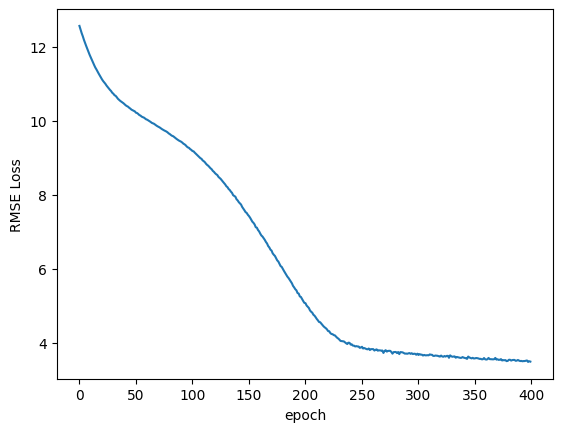

In [44]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Zweryfikuj model

Przepuścimy cały zbiór testowy przez model i porównamy wyniki z rzeczywistymi etykietami.  
Na tym etapie **nie chcemy aktualizować wag i biasów**, dlatego użyjemy kontekstu `torch.no_grad()`.

---

## RMSE – Root Mean Squared Error

**RMSE** (pierwiastek z błędu średniokwadratowego) to jedna z najczęściej stosowanych metryk do oceny jakości modeli regresyjnych.  

### Jak działa?

1. Model przewiduje wartości $\hat{y}_i$, a my mamy wartości rzeczywiste $y_i$.  
2. Liczymy różnice (residua): $e_i = y_i - \hat{y}_i$.  
3. Podnosimy różnice do kwadratu: $e_i^2$ – dzięki temu nie ma znaczenia znak i mocniej karzemy duże błędy.  
4. Liczymy średnią z tych kwadratów – to **MSE** (*Mean Squared Error*).  
5. Bierzemy pierwiastek kwadratowy → otrzymujemy **RMSE**.  

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 }
$$

---

### Interpretacja

- RMSE jest **w tej samej jednostce**, co przewidywana wartość (np. złote, kilometry, stopnie Celsjusza).  
- **Im mniejsze RMSE, tym lepiej** – oznacza to, że przewidywania są bliżej wartości rzeczywistych.  
- RMSE jest **wrażliwe na duże odchylenia** (outliers), ponieważ błędy są podnoszone do kwadratu.  

👉 Możesz myśleć o RMSE jako o **„średnim błędzie” w jednostkach przewidywanej wielkości**.

```

Chcesz, żebym przygotował jeszcze krótką tabelkę porównującą RMSE z MAE i R², żeby było jasne, kiedy którą metrykę wybrać?
```


In [45]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.43492579


Oznacza to, że średnio prognozy różnią się od wartości rzeczywistej o ±\$3.31.

Spójrzmy teraz na pierwsze 10 przewidywanych wartości:

In [46]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.2129   2.9000   1.3129
 2.  23.5540   5.7000  17.8540
 3.   4.2738   7.7000   3.4262
 4.  11.8067  12.5000   0.6933
 5.   4.0164   4.1000   0.0836
 6.   4.4431   5.3000   0.8569
 7.   1.5540   3.7000   2.1460
 8.  13.7873  14.5000   0.7127
 9.   5.6618   5.7000   0.0382
10.  14.4415  10.1000   4.3415


Wiele predykcji pomyliło się o kilka centów, ale niektóre nawet o kilkanaście dolarów.


Spróbuj zmieniać rozmiar partii, wielkość zbioru testowego i liczbę epok, aby uzyskać lepszy model

## Zapisz model

Wytrenowany model warto zachować, by później móc wykorzystać go do nowych danych.  
Najlepszą praktyką jest zapis **stanu modelu** (wag i biasów), a nie całej definicji.  

Upewnij się też, że zapisujesz wyłącznie **model po treningu**, aby nie nadpisać poprzedniej wersji nieprzeszkolonym modelem.  

Więcej informacji znajdziesz w [oficjalnym poradniku PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).


In [47]:
# Pamiętaj, żeby zapisać model dopiero po zakończeniu treningu!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Wczytanie zapisanego modelu (od zera)

Możemy wczytać wyuczone wagi i biasy z zapisanej wersji.  
Jeśli dopiero otworzyłeś notatnik, uruchom najpierw **standardowe importy** i **definicje funkcji**.  

Aby to zademonstrować, przed dalszą pracą **zrestartuj kernel**.


In [62]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

criterion = nn.MSELoss()  # później przekształcimy to na RMSE
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

import time
start_time = time.time()

epochs = 400
losses = []

for i in range(epochs):
    i+=1
    y_pred = model2(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # sprytny trik, żeby oszczędzić miejsce na ekranie:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:   1  loss: 12.50666714
epoch:  26  loss: 10.72367573
epoch:  51  loss: 10.12331867
epoch:  76  loss: 9.70387554
epoch: 101  loss: 9.19267559
epoch: 126  loss: 8.44067955
epoch: 151  loss: 7.45702410
epoch: 176  loss: 6.23063993
epoch: 201  loss: 4.99481392
epoch: 226  loss: 4.14790440
epoch: 251  loss: 3.81091595
epoch: 276  loss: 3.70445657
epoch: 301  loss: 3.64069176
epoch: 326  loss: 3.58935976
epoch: 351  loss: 3.55485582
epoch: 376  loss: 3.53260016


epoch:   1  loss: 12.54976082
epoch:  26  loss: 12.54480553
epoch:  51  loss: 12.54600620
epoch:  76  loss: 12.54979801
epoch: 101  loss: 12.54709244
epoch: 126  loss: 12.55134201
epoch: 151  loss: 12.55424976
epoch: 176  loss: 12.54741573
epoch: 201  loss: 12.54950523
epoch: 226  loss: 12.55294704
epoch: 251  loss: 12.55544281
epoch: 276  loss: 12.55192089
epoch: 301  loss: 12.55470371
epoch: 326  loss: 12.54674244
epoch: 351  loss: 12.54883003
epoch: 376  loss: 12.54930496
epoch: 400  loss: 12.54578018

Duration: 40 seconds


Zdefiniujmy model. 

Zanim załadujemy zapisane ustawienia, musimy utworzyć instancję TabularModel z tymi samymi parametrami co wcześniej 
(rozmiary embeddingów, liczba zmiennych ciągłych, rozmiar wyjścia, rozmiary warstw i wartość dropout)

In [49]:
# emb_szs = [(24, 12), (2, 1), (7, 4)]
# model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Gdy model jest gotowy, załadowanie zapisanych ustawień to formalność.\n

In [59]:
# model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
# model2.eval() # koniecznie wykonaj ten krok!

In [60]:
# model.load_state_dict(torch.load("TaxiFareClssModel.pt"))
# model.eval()

Zdefiniujemy teraz funkcję, która przyjmie nowe dane użytkownika, wykona wszystkie opisane wcześniej kroki przetwarzania i przepuści dane przez wytrenowany model.\n

In [64]:

def build_dataframe(
    plat: float, plong: float,
    dlat: float, dlong: float,
    psngr: int, dt: str
) -> pd.DataFrame:
    """Buduje bazowy DataFrame z pojedynczym rekordem."""
    return pd.DataFrame({
        'pickup_latitude': plat,
        'pickup_longitude': plong,
        'dropoff_latitude': dlat,
        'dropoff_longitude': dlong,
        'passenger_count': psngr,
        'EDTdate': pd.to_datetime(dt)
    }, index=[0])


def add_distance_feature(df: pd.DataFrame) -> pd.DataFrame:
    """Dodaje kolumnę z odległością (w km)."""
    df['dist_km'] = haversine_distance(
        df, 'pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude'
    )
    return df


def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    """Dodaje cechy związane z czasem (Hour, AMorPM, Weekday)."""
    df['Hour'] = df['EDTdate'].dt.hour
    df['AMorPM'] = np.where(df['Hour'] < 12, 0, 1)
    df['Weekday'] = (
        df['EDTdate']
        .dt.strftime("%a")
        .replace(
            ['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
            [0,1,2,3,4,5,6]
        )
        .astype('int64')
    )
    return df


def dataframe_to_tensors(df: pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    """Konwertuje DataFrame do tensorów kategorii i wartości ciągłych."""
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = [
        'pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude',
        'passenger_count', 'dist_km'
    ]

    xcats = torch.tensor(
        np.stack([df[col].values for col in cat_cols], 1),
        dtype=torch.int64
    )
    xconts = torch.tensor(
        np.stack([df[col].values for col in cont_cols], 1),
        dtype=torch.float
    )
    return xcats, xconts


def prepare_features(
    plat: float, plong: float,
    dlat: float, dlong: float,
    psngr: int, dt: str
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Przygotowuje cechy wejściowe (kategoryczne i ciągłe) 
    na podstawie podanych parametrów.
    """
    df = build_dataframe(plat, plong, dlat, dlong, psngr, dt)
    df = add_distance_feature(df)
    df = add_datetime_features(df)
    return dataframe_to_tensors(df)


def predict_fare(
    model,
    plat: float, plong: float,
    dlat: float, dlong: float,
    psngr: int, dt: str
) -> float:
    """
    Zwraca przewidywaną opłatę za kurs taksówką na podstawie modelu i parametrów wejściowych.
    """
    xcats, xconts = prepare_features(plat, plong, dlat, dlong, psngr, dt)
    model.eval()
    with torch.no_grad():
        prediction = model(xcats, xconts)

    return prediction.item()


## Przepuść nowe dane przez wytrenowany model

Dla wygody poniżej znajdziesz wartości minimalne i maksymalne każdej zmiennej:

| Kolumna           | Minimum               | Maksimum             |
|-------------------|-----------------------|----------------------|
| pickup_latitude   | 40                    | 41                   |
| pickup_longitude  | -74.5                 | -73.3                |
| dropoff_latitude  | 40                    | 41                   |
| dropoff_longitude | -74.5                 | -73.3                |
| passenger_count   | 1                     | 5                    |
| EDTdate           | 2010-04-11 00:00:00   | 2010-04-24 23:59:42  |


In [66]:
fare = predict_fare(
    model2,
    plat=40.0,
    plong=-74.5,
    dlat=41,
    dlong=-73.3,
    psngr=1,
    dt="2010-04-12 08:24:00"
)
print(f"The predicted fare amount is ${fare:.2f}")


The predicted fare amount is $192.65


/var/folders/ff/6wst9f1n1g96lc__ld426szh0000gn/T/ipykernel_84035/566468548.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(


<strong>Zachowaj ostrożność!</strong> Odległość odpowiadająca 1 stopniowi szerokości geograficznej (od 40 do 41) to 111 km (69 mil), a 1 stopniowi długości (od -73 do -74) – 85 km (53 mile). 

Najdłuższy kurs w zbiorze różnił się zaledwie o 0.243 stopnia szerokości i 0.284 stopnia długości. 

Średnia różnica dla obu wynosi ok. 0.02. 

Aby otrzymać wiarygodne prognozy, korzystaj z wartości położonych blisko siebie.

## Zróbmy to jeszcze w TensorFlow 

## Analogiczny model w TensorFlow/Keras

Poniższa sekcja odtwarza sieć tablicową w Keras, korzystając z tych samych cech kategorycznych i ciągłych oraz analogicznej architektury (embeddingi + MLP).

In [ ]:
type(cats[0])

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Ustawiamy ziarno losowe (seed), żeby wyniki były powtarzalne
tf.random.set_seed(42)
np.random.seed(42)

# Konwersja danych wejściowych z tensora PyTorch/TF na numpy arrays 
# i rzutowanie na odpowiednie typy (int32 dla kategorii, float32 dla liczb zmiennoprzecinkowych).
# Dzięki temu model w Kerasie dostaje dane w formacie, którego oczekuje.
cat_train_np = cat_train.numpy().astype('int32')
cat_test_np = cat_test.numpy().astype('int32')
con_train_np = con_train.numpy().astype('float32')
con_test_np = con_test.numpy().astype('float32')
y_train_np = y_train.numpy().astype('float32')
y_test_np = y_test.numpy().astype('float32')

# Przygotowanie słownika wejść dla modelu:
# - każdy atrybut kategoryczny dostaje osobny "wektor kolumnowy"
# - dane ciągłe grupujemy razem w jednej macierzy pod kluczem 'cont'
train_inputs = {f'cat_{i}': cat_train_np[:, i:i+1] for i in range(cat_train_np.shape[1])}
test_inputs = {f'cat_{i}': cat_test_np[:, i:i+1] for i in range(cat_test_np.shape[1])}
train_inputs['cont'] = con_train_np
test_inputs['cont'] = con_test_np

# Informacyjnie wypisujemy wersję TensorFlow (pomocne przy debugowaniu i odtwarzaniu wyników)
print(f'TensorFlow version: {tf.__version__}')


In [ ]:
inputs_cat = []     # lista wejść dla zmiennych kategorycznych
embeddings = []     # lista embeddingów odpowiadających tym wejściom

# Tworzymy osobne wejście i warstwę embedding dla każdej cechy kategorycznej
for idx, (cardinality, emb_dim) in enumerate(emb_szs):
    # Wejście (pojedyncza liczba całkowita reprezentująca kategorię)
    input_layer = keras.Input(shape=(1,), name=f'cat_{idx}')
    
    # Warstwa embedding: zamiana indeksu kategorii na gęsty wektor o wymiarze emb_dim
    embed = keras.layers.Embedding(cardinality, emb_dim, name=f'emb_{idx}')(input_layer)
    
    # Reshape: spłaszczenie (bo Embedding zwraca kształt (batch, 1, emb_dim))
    embed = keras.layers.Reshape((emb_dim,), name=f'emb_{idx}_reshape')(embed)
    
    # Zbieramy do list
    embeddings.append(embed)
    inputs_cat.append(input_layer)

embeddings, inputs_cat

In [ ]:
# łączymy je w jeden wektor cech
cat_features = keras.layers.Concatenate(name='cats_concat')(embeddings)


# Dropout dla embeddingów — redukuje przeuczenie
cat_features = keras.layers.Dropout(0.4, name='cats_dropout')(cat_features)

# Wejście dla zmiennych ciągłych
cont_input = keras.Input(shape=(con_train_np.shape[1],), name='cont')

# BatchNormalization — normalizacja danych ciągłych (przyspiesza uczenie)
cont_features = keras.layers.BatchNormalization(name='cont_bn')(cont_input)

# Połączenie cech kategorycznych i ciągłych w jeden wektor
x = keras.layers.Concatenate(name='features_concat')([cat_features, cont_features])

# Klasyczne gęste warstwy ukryte (MLP)
for i, units in enumerate([200, 100]):
    # Gęsta warstwa w pełni połączona z ReLU
    x = keras.layers.Dense(units, activation='relu', name=f'dense_{i}')(x)
    # Normalizacja batchowa stabilizuje rozkład aktywacji
    x = keras.layers.BatchNormalization(name=f'bn_{i}')(x)
    # Dropout dla redukcji przeuczenia
    x = keras.layers.Dropout(0.4, name=f'dropout_{i}')(x)

# Warstwa wyjściowa — 1 neuron (predykcja ceny przejazdu)
output = keras.layers.Dense(1, name='fare')(x)

# Składamy cały model — wejścia to embeddingi + cechy ciągłe
tf_model = keras.Model(inputs=inputs_cat + [cont_input], outputs=output, name='taxi_fare_model_tf')

# Kompilacja modelu:
# - optimizer Adam (0.001)
# - funkcja straty: MSE (błąd średniokwadratowy)
# - metryka: RMSE (bardziej interpretowalna w jednostkach ceny)
tf_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Podsumowanie modelu (lista warstw, parametry, kształty)
tf_model.summary()

In [ ]:
# Callback: EarlyStopping
# Monitorujemy walidacyjną metrykę RMSE (val_rmse).
# Jeśli przez 20 epok nie będzie poprawy, zatrzymujemy trening.
# restore_best_weights=True oznacza, że model przywróci najlepsze wagi z okresu treningu.
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_rmse',
    patience=20,
    restore_best_weights=True
)

# Trening modelu:
# - dane treningowe (wejścia + etykiety)
# - walidacja na zbiorze testowym
# - max 200 epok, batch_size=512
# - verbose=0, czyli bez spamowania logami
# - EarlyStopping, żeby nie przeuczać modelu
history = tf_model.fit(
    train_inputs,
    y_train_np,
    validation_data=(test_inputs, y_test_np),
    epochs=200,
    batch_size=512,
    verbose=0,
    callbacks=[early_stop]
)

# Historia treningu (loss + metryki) do DataFrame dla wygodnego przeglądania
history_df = pd.DataFrame(history.history)
print(history_df[['rmse', 'val_rmse']].tail())

# Ewaluacja na danych testowych — obliczamy stratę i RMSE
test_loss, test_rmse = tf_model.evaluate(test_inputs, y_test_np, verbose=0)
print(f'Test RMSE: {test_rmse:.4f}')

# Predykcje na zbiorze testowym
preds = tf_model.predict(test_inputs, verbose=0).flatten()
actuals = y_test_np.flatten()

# Porównanie: przewidywane vs rzeczywiste wartości (pierwsze 10 przypadków)
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(10):
    diff = abs(preds[i] - actuals[i])  # różnica absolutna
    print(f'{i+1:2}. {preds[i]:8.4f} {actuals[i]:8.4f} {diff:8.4f}')


In [ ]:

def predict_fare_keras(model, plat, plong, dlat, dlong, psngr, dt):
    xcats, xconts = prepare_features(plat, plong, dlat, dlong, psngr, dt)
    keras_inputs = {f'cat_{i}': xcats.numpy()[:, i:i+1].astype('int32') for i in range(xcats.shape[1])}
    keras_inputs['cont'] = xconts.numpy().astype('float32')
    prediction = model.predict(keras_inputs, verbose=0)
    return float(prediction.squeeze())

fare_tf = predict_fare_keras(
    tf_model,
    plat=40.0,
    plong=-74.5,
    dlat=41,
    dlong=-73.3,
    psngr=1,
    dt="2010-04-12 08:24:00"
)
print(f"TensorFlow prognoza opłaty: ${fare_tf:.2f}")

### uwaga - w przykladzie PyTorch nie byo early stoppingu. Trzeba by go implementowac ręcznie w petli uczenia

Coś w ten deseń:


```python
best_val_loss = float("inf")
patience = 10
counter = 0

for epoch in range(epochs):
    train_one_epoch(...)   # trening na batchach
    val_loss = evaluate_on_validation(...)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# przywracamy najlepsze wagi
model.load_state_dict(best_model_wts)
```